<a href="https://colab.research.google.com/github/Ouvryy/69LaTrik/blob/main/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
import torch
from torch import nn
import numpy as np
from torch.utils.data import DataLoader

In [43]:
def get_device():
    """Return GPU device if available, or fall back to CPU"""

    return torch.device(
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )


device = get_device()
print(f"PyTorch {torch.__version__}, using {device} device")

PyTorch 2.6.0+cu124, using cpu device


In [44]:
device = get_device()
print(f"PyTorch {torch.__version__}, using {device} device")

PyTorch 2.6.0+cu124, using cpu device


In [45]:
# Hyperparameters
n_samples = 1000  # Number of data samples
output_dim = 3  # Number of classes
n_epochs = 60  # Number of training iterations on the whole dataset
learning_rate = 0.001  # Rate of parameter change during gradient descent
batch_size = 32  # Number of samples used for one gradient descent step

In [46]:
# Generate a 2D dataset with scikit-learn
inputs, targets = make_blobs(
    n_samples=n_samples,
    n_features=2,  # x- and y-coordinates
    centers=output_dim,
    cluster_std=0.5,
    random_state=0,
)
print(f"Inputs: {inputs.shape}. targets: {targets.shape}")
assert inputs.shape == (n_samples, 2)
assert targets.shape == (n_samples,)

Inputs: (1000, 2). targets: (1000,)


In [47]:
# Convert dataset to PyTorch tensors and put them on GPU memory (if available)
x_train = torch.from_numpy(inputs).float().to(device)
y_train = torch.from_numpy(targets).int().to(device)

In [48]:
# Create data loader for loading data as randomized batches
train_dataloader = DataLoader(
    list(zip(x_train, y_train)), batch_size=batch_size, shuffle=True
)

# Number of batches in an epoch (= n_samples / batch_size, rounded up)
n_batches = len(train_dataloader)
assert n_batches == math.ceil(n_samples / batch_size)

In [49]:
# Create a logistic regression model for the 2D dataset
model = nn.Linear(in_features=2, out_features=output_dim).to(device)

# Print model architecture
print(model)

Linear(in_features=2, out_features=3, bias=True)


In [50]:
def get_parameter_count(model):
    """Return the number of trainable parameters for a PyTorch model"""

    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Print model architecture
print(model)

# Compute and print parameter count
n_params = get_parameter_count(model)
print(f"Model has {n_params} trainable parameters")


Linear(in_features=2, out_features=3, bias=True)
Model has 9 trainable parameters


In [51]:
# Compute and print parameter count
n_params = get_parameter_count(model)
print(f"Model has {n_params} trainable parameters")
# Linear layers have (in_features + 1) * out_features parameters
assert n_params == 3 * output_dim

Model has 9 trainable parameters


In [52]:
# Use a vanilla mini-batch stochastic gradient descent optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [53]:
# Use cross-entropy loss function for this multiclass classification task.
# Softmax is computed internally to convert outputs into probabilities
criterion = nn.CrossEntropyLoss()

In [54]:
# Use a vanilla mini-batch stochastic gradient descent optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [55]:
# Set the model to training mode - important for batch normalization and dropout layers.
# Unnecessary here but added for best practices
model.train()

# Train the model
for epoch in range(n_epochs):
    # Total loss for epoch, divided by number of batches to obtain mean loss
    epoch_loss = 0

    # Number of correct predictions in an epoch, used to compute epoch accuracy
    n_correct = 0

    # For each batch of data
    for x_batch, y_batch in train_dataloader:
        # Forward pass
        y_pred = model(x_batch)

        # Compute loss value
        loss = criterion(y_pred, y_batch.long())

        # Gradient descent step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            # Accumulate data for epoch metrics: loss and number of correct predictions
            epoch_loss += loss.item()
            n_correct += (
                (model(x_batch).argmax(dim=1) == y_batch).float().sum().item()
            )

    # Compute epoch metrics
    mean_loss = epoch_loss / n_batches
    epoch_acc = n_correct / n_samples

    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch [{(epoch + 1):3}/{n_epochs:3}] finished. Mean loss: {mean_loss:.5f}. Accuracy: {epoch_acc * 100:.2f}%"
        )

Epoch [  5/ 60] finished. Mean loss: 1.42954. Accuracy: 0.20%
Epoch [ 10/ 60] finished. Mean loss: 1.23976. Accuracy: 12.20%
Epoch [ 15/ 60] finished. Mean loss: 1.09940. Accuracy: 32.20%
Epoch [ 20/ 60] finished. Mean loss: 0.98626. Accuracy: 34.50%
Epoch [ 25/ 60] finished. Mean loss: 0.89239. Accuracy: 43.70%
Epoch [ 30/ 60] finished. Mean loss: 0.81368. Accuracy: 54.60%
Epoch [ 35/ 60] finished. Mean loss: 0.74939. Accuracy: 65.10%
Epoch [ 40/ 60] finished. Mean loss: 0.69168. Accuracy: 73.60%
Epoch [ 45/ 60] finished. Mean loss: 0.64558. Accuracy: 81.90%
Epoch [ 50/ 60] finished. Mean loss: 0.60466. Accuracy: 87.90%
Epoch [ 55/ 60] finished. Mean loss: 0.56767. Accuracy: 91.00%
Epoch [ 60/ 60] finished. Mean loss: 0.53329. Accuracy: 93.40%


In [56]:
def plot_decision_boundaries(model, x, y, title, device):
    """
    Plot the decision boundaries and data points for a PyTorch classifier.

    Args:
        model (torch.nn.Module): Trained PyTorch model
        inputs (torch.Tensor): Input features of shape (n_samples, 2)
        targets (torch.Tensor): Labels of shape (n_samples,)
        title (str): Plot title
        device (torch.device): device where data on model are stored
    """
    # Set the model to evaluation mode - important for batch normalization and dropout layers.
    # Unnecessary here but added for best practices
    model.eval()

    # Convert inputs and targets to NumPy arrays
    x_cpu = x.detach().cpu().numpy()
    y_cpu = y.detach().cpu().numpy()

    # Determine bounds for the grid
    x_min, x_max = x_cpu[:, 0].min() - 1, x_cpu[:, 0].max() + 1
    y_min, y_max = x_cpu[:, 1].min() - 1, x_cpu[:, 1].max() + 1

    # Generate a grid of points with distance h between them
    h = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Convert mesh to PyTorch tensors and put it on device memory
    x_mesh = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float).to(device)

    # Get predictions for mesh points
    with torch.no_grad():
        y_mesh = model(x_mesh).detach().cpu()
        if y_mesh.shape[1] > 1:  # For multi-class problems
            y_mesh = torch.argmax(y_mesh, dim=1)

            # Reshape predictions to match mesh shape
            y_mesh = y_mesh.numpy().reshape(xx.shape)

            # Create the plot
            plt.figure()

            # Plot decision boundaries
            plt.contourf(xx, yy, y_mesh, alpha=0.4, cmap="RdYlBu")
            plt.contour(xx, yy, y_mesh, colors="k", linewidths=0.5)

            # Plot data points
            scatter = plt.scatter(
                x_cpu[:, 0], x_cpu[:, 1], c=y_cpu, cmap="RdYlBu", linewidth=1, alpha=0.8
            )
        else:  # For binary classification
            # Reshape predictions to match mesh shape
            y_mesh = y_mesh.numpy().reshape(xx.shape)

            # Create the plot
            plt.figure()

            # Plot decision boundary
            plt.contourf(xx, yy, y_mesh, cmap=plt.colormaps.get_cmap("Spectral"))

            # Plot data points
            cm_bright = ListedColormap(["#FF0000", "#0000FF"])
            scatter = plt.scatter(x_cpu[:, 0], x_cpu[:, 1], c=y_cpu, cmap=cm_bright)

    # Add legend
    unique_labels = np.unique(y_cpu)
    legend_elements = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=scatter.cmap(scatter.norm(label.item())),
            markersize=10,
            label=f"Class {label.item():.0f}",
        )
        for label in unique_labels
    ]
    plt.legend(handles=legend_elements)

    plt.title(title)

    return plt.gcf()

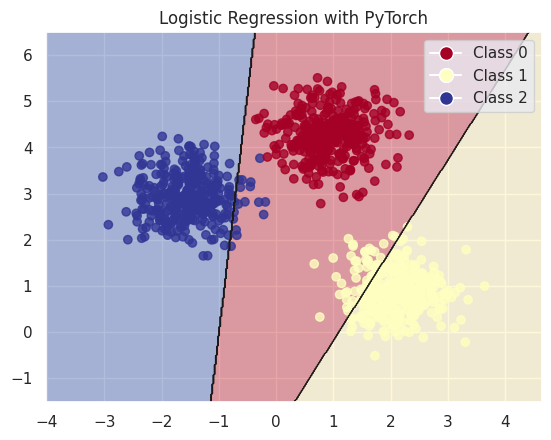

In [57]:
# Improve plots appearance
sns.set_theme()

_ = plot_decision_boundaries(
    model=model,
    x=x_train,
    y=y_train,
    title="Logistic Regression with PyTorch",
    device=device,
)
plt.show()